In [1]:
import pandas as pd
from sklearn import datasets
import tensorflow as tf
from sklearn.datasets import load_boston
import numpy as np

In [2]:
boston = load_boston()
df = pd.DataFrame(boston.data)

In [3]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [4]:
df.columns = boston.feature_names
df['PRICE'] = boston.target

In [5]:
df.size

7084

In [6]:
df['CHAS'] = df['CHAS'].map({1:'yes', 0:'no'})

In [7]:
### Create train/test set
df_train = df.sample(frac=0.8, random_state=200)
df_test = df.drop(df_train.index)

In [8]:
print(df_train.shape, df_test.shape)

(405, 14) (101, 14)


## Facets Deep Dive

In [9]:
!pip install jupyter_contrib_nbextensions

In [10]:
!echo `pwd` /` ls facets`

/home/kirubel/Tensflow_t/guru99/jupyter-py /AUTHORS colab_facets.ipynb CONTRIBUTING.md CONTRIBUTORS facets facets_atlasmaker facets-dist facets_dive facets_overview img LICENSE README.md WORKSPACE


In [11]:
cd facets

/home/kirubel/Tensflow_t/guru99/jupyter-py/facets


In [12]:
!sudo jupyter nbextension install facets-dist/

[sudo] password for kirubel: 


In [ ]:
kirubel7

In [ ]:
import getpass
import os

password = getpass.getpass()
command = "sudo -S jupyter nbextension install facets-dist/ --user"
os.system('echo %s | %s' % (password, command))

In [14]:
import sys
sys.path.append('/home/kirubel/Tensflow_t/guru99/jupyter-py/facets/facets_overview/python')

In [15]:
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

In [16]:
# Calculate the feature staticstics proto from the
# datasets and stringify it for use in facets overview
import base64

gfsg = GenericFeatureStatisticsGenerator()

proto = gfsg.ProtoFromDataFrames([{'name':'train', 'table':df_train},
                                 {'name':'test', 'table':df_test}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [17]:
# Display the facets overview visualization for this data# Displ 
from IPython.core.display import display, HTML

HTML_TEMPLATE = """<link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

## Graph

In [19]:
## Choose important feature and further check with Dive
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

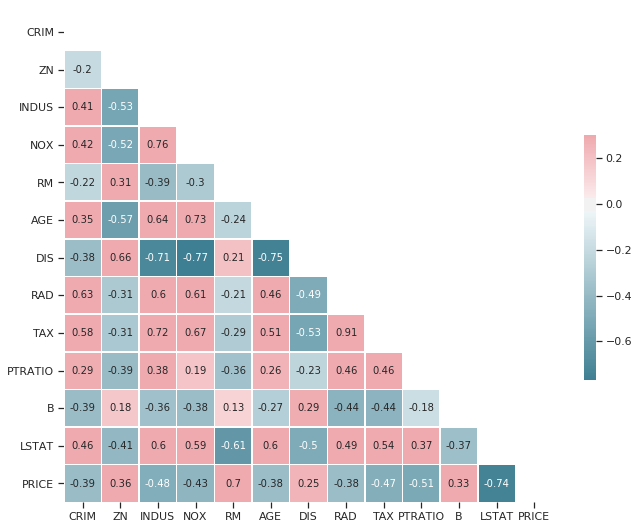

In [20]:
# Compute the correlation matrix
corr = df.corr('pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ration
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           annot=True, square=True, linewidths=.5, cbar_kws={"shrink":.5})

The choice corresponds to the variables with strong correlation with PRICE
* INDUS
* NOX
* RM
* LSTAT

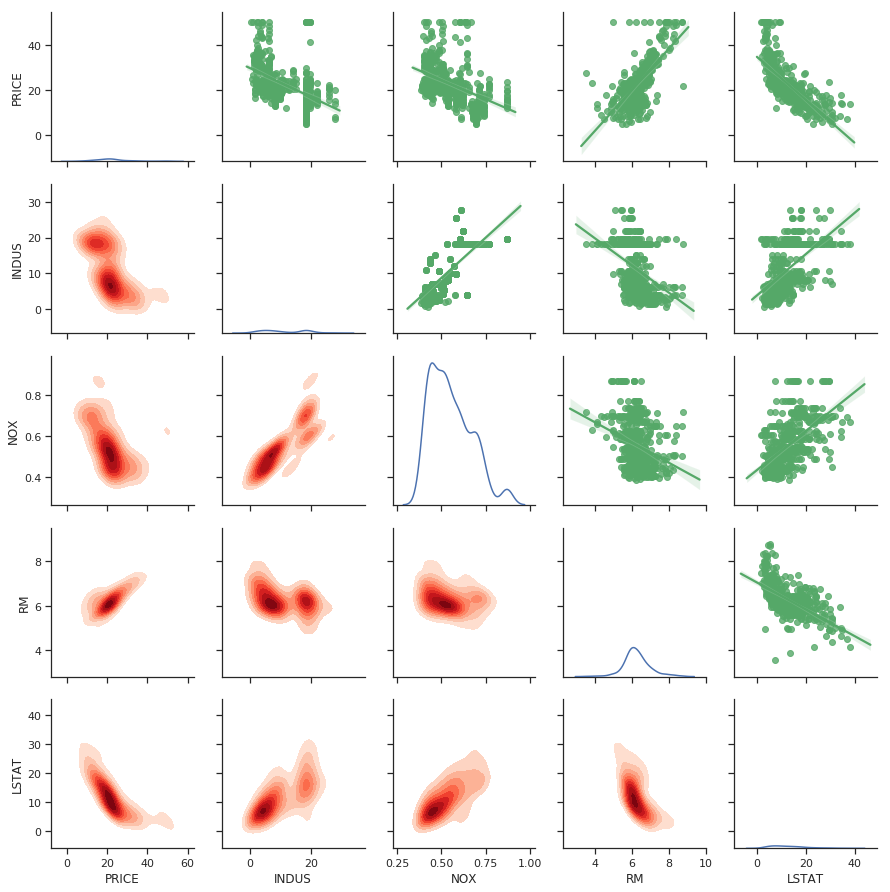

In [21]:
attributes = ["PRICE", "INDUS", "NOX","RM","LSTAT"]

g = sns.PairGrid(df[attributes])
g = g.map_upper(sns.regplot, color="g")
g = g.map_lower(sns.kdeplot, cmap="Reds", shade=True, shade_lowest=False)
g = g.map_diag(sns.kdeplot)

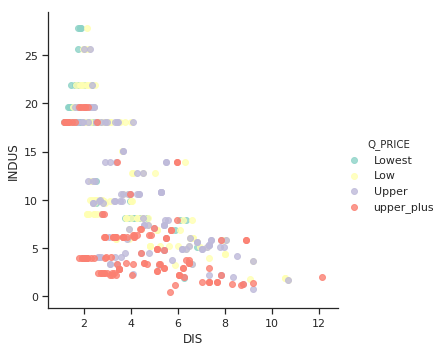

In [25]:
## Check non linearity with iimportant features
df['Q_PRICE'] = pd.qcut(df['PRICE'], 4, labels=["Lowest", "Low", "Upper", "upper_plus"])

## Show non linearity between RM and LSTAT
ax = sns.lmplot(x="DIS", y="INDUS", hue="Q_PRICE", data=df, fit_reg = False, palette = "Set3")

In [24]:
df['Q_PRICE'] = pd.qcut(df['PRICE'], 4, labels=["Lowest", "Low", "Upper", "upper_plus"])

sprite_size = 32 if len(df.index)>50000 else 64
jsonstr = df.to_json(orient='records')


# Display thde Dive visualization for this data
from IPython.core.display import display, HTML

# Create Facets template  
HTML_TEMPLATE = """<link rel="import" href="/nbextensions/facets-dist/facets-jupyter.html">
        <facets-dive sprite-image-width="{sprite_size}" sprite-image-height="{sprite_size}" id="elem" height="600"></facets-dive>
        <script>
          document.querySelector("#elem").data = {jsonstr};
        </script>"""

# Load the json dataset and the sprite_size into the template
html = HTML_TEMPLATE.format(jsonstr=jsonstr, sprite_size=sprite_size)

# Display the template
display(HTML(html))

## Tensorflow 

In [29]:
from sklearn import preprocessing
def standardize_data(df):
    X_scaled = preprocessing.scale(df[['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD',
                                      'TAX','PTRATIO','B','LSTAT']])
    X_scaled_df = pd.DataFrame(X_scaled, columns=['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','RAD',
                                      'TAX','PTRATIO','B','LSTAT'])
    df_scaled = pd.concat([X_scaled_df, df['CHAS'], df['PRICE']], axis=1,join='inner')
    return df_scaled

In [30]:
df_train_scale = standardize_data(df_train)
df_test_scale = standardize_data(df_test)

### Basic regression: Benchmark

In [32]:
## Add features to the bucket: 
### Define continuous list
CONTI_FEATURES  = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT']
CATE_FEATURES = ['CHAS']

In [34]:
# Convert the features into a numeric column or catagorical column
continuous_features = [tf.feature_column.numeric_column(k) for k in CONTI_FEATURES]
catagorical_features = [tf.feature_column.categorical_column_with_vocabulary_list('CHAS',['yes','no'])]


In [35]:
# Create the model with the linearRegressor
model = tf.estimator.LinearRegressor(
    model_dir="train_Boston",
    feature_columns=catagorical_features + continuous_features)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'train_Boston', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fccaa71e4e0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [36]:
# Each column in the train or test data is converted into a Tensor with the function get_input_fn
FEATURES = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT','CHAS']
LABEL = 'PRICE'

def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle = True):
    return tf.estimator.inputs.pandas_input_fn(
        x=pd.DataFrame({k : data_set[k].values for k in FEATURES}),
        y = pd.Series(data_set[LABEL].values),
        batch_size=n_batch,
        num_epochs=num_epochs,
        shuffle=shuffle)

In [37]:
# estimate the model on the train data
model.train(input_fn=get_input_fn(df_train_scale, num_epochs=None, n_batch=128,shuffle=False), steps=1000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into train_Boston/model.ckpt.
INFO:tensorflow:loss = 56417.703, step = 1
INFO:tensorflow:global_step/sec: 229.009
INFO:tensorflow:loss = 76982.47, step = 101 (0.443 sec)
INFO:tensorflow:global_step/sec: 284.71
INFO:tensorflow:loss = 21244.963, step = 201 (0.349 sec)
INFO:tensorflow:global_step/sec: 300.6

In [38]:
# lastly, estimate the performances of the model on the test set
model.evaluate(input_fn=get_input_fn(df_test_scale,
                                     num_epochs=1,
                                     n_batch = 128,
                                     shuffle=False),
              steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-25T13:33:16Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from train_Boston/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-25-13:33:17
INFO:tensorflow:Saving dict for global step 1000: average_loss = 86.922104, global_step = 1000, label/mean = 26.01579, loss = 1651.52, prediction/mean = 18.426308
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: train_Boston/model.ckpt-1000


{'average_loss': 86.922104,
 'label/mean': 26.01579,
 'loss': 1651.52,
 'prediction/mean': 18.426308,
 'global_step': 1000}

In [39]:
def interaction_term(var_1, var_2, name):
    t_train = df_train_scale[var_1]*df_train_scale[var_2]
    train = t_train.rename(name)
    t_test = df_test_scale[var_1]*df_test_scale[var_2]
    test = t_test.rename(name)
    return train, test

In [48]:
interation_ind_ns_train, interation_ind_ns_test = interaction_term('INDUS','NOX','INDUS_NOS')

In [49]:
def triple_interaction_term(var_1, var_2,var_3, name):
    t_train = df_train_scale[var_1]*df_train_scale[var_2]*df_train_scale[var_3]
    train = t_train.rename(name)
    t_test = df_test_scale[var_1]*df_test_scale[var_2]*df_test_scale[var_3]
    test = t_test.rename(name)
    return train, test

interation_ind_ns_dis_train, interation_ind_ns_dis_test= triple_interaction_term('INDUS', 'NOX', 'DIS','INDUS_NOS_DIS')

In [50]:
df_train_new = pd.concat([df_train_scale,
                          interation_ind_ns_train,
                          interation_ind_ns_dis_train],
                         axis=1, join='inner')
df_test_new = pd.concat([df_test_scale,
                         interation_ind_ns_test,
                         interation_ind_ns_dis_test],
                         axis=1, join='inner')
df_train_new.head(5)

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS,PRICE,INDUS_NOS,INDUS_NOS_DIS
2,-0.278174,-0.47701,-0.464046,-0.162933,-0.188265,0.812916,0.105941,-0.661477,-0.616881,1.147718,0.444455,0.803221,no,34.7,0.075608,0.008010
4,1.014608,-0.47701,0.992729,1.594192,-0.595967,0.987593,-0.907724,1.636106,1.502932,0.776192,-1.278797,1.504488,no,36.2,1.582601,-1.436565
5,-0.409562,-0.47701,-1.155868,-0.589166,1.036257,0.620414,-0.164461,-0.891235,-0.835358,-0.338387,0.444455,-1.025327,no,28.7,0.680999,-0.111997
8,-0.370330,-0.47701,-0.747795,-0.432591,-0.157121,0.798656,-0.346465,-0.201960,-0.616881,-0.524150,0.426162,1.182209,no,16.5,0.323489,-0.112078
9,1.828346,-0.47701,0.992729,1.246247,-2.699598,0.795092,-1.129861,1.636106,1.502932,0.776192,-0.779497,2.450575,no,18.9,1.237185,-1.397847


In [52]:
CONTI_FEATURES_NEW  = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT',
                       'INDUS_NOS', 'INDUS_NOS_DIS']
### Define categorical list
continuous_features_new = [tf.feature_column.numeric_column(k) for k in CONTI_FEATURES_NEW]
model = tf.estimator.LinearRegressor(
    model_dir="train_Boston_1", 
    feature_columns= catagorical_features + continuous_features_new)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'train_Boston_1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcca513cac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [53]:
FEATURES = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT','INDUS_NOS', 'INDUS_NOS_DIS','CHAS']
LABEL= 'PRICE'
def get_input_fn(data_set, num_epochs=None, n_batch = 128, shuffle=True):
    return tf.estimator.inputs.pandas_input_fn(
       x=pd.DataFrame({k: data_set[k].values for k in FEATURES}),
       y = pd.Series(data_set[LABEL].values),
       batch_size=n_batch,   
       num_epochs=num_epochs,
       shuffle=shuffle)

In [54]:
model.train(input_fn=get_input_fn(df_train_new, 
                                      num_epochs=None,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into train_Boston_1/model.ckpt.
INFO:tensorflow:loss = 56417.703, step = 1
INFO:tensorflow:global_step/sec: 217.706
INFO:tensorflow:loss = 65522.47, step = 101 (0.463 sec)
INFO:tensorflow:global_step/sec: 275.683
INFO:tensorflow:loss = 15383.178, step = 201 (0.361 sec)
INFO:tensorflow:global_step/sec: 290.401
INFO:tensorflow:loss = 22020.266, step = 301 (0.345 sec)
INFO:tensorflow:global_step/sec: 202.105
INFO:tensorflow:loss = 28208.574, step = 401 (0.511 sec)
INFO:tensorflow:global_step/sec: 229.305
INFO:tensorflow:loss = 7606.2295, step = 501 (0.422 sec)
INFO:tensorflow:global_step/sec: 250.579
INFO:tensorflow:loss = 26681.047, step = 601 (0.397 sec)
INFO:tensorflow:global_step/sec: 268.185
INFO:tensorflow:los

In [55]:
model.evaluate(input_fn=get_input_fn(df_test_new, 
                                      num_epochs=1,
                                      n_batch = 128,
                                      shuffle=False),
                                      steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-25T13:47:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from train_Boston_1/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-25-13:47:21
INFO:tensorflow:Saving dict for global step 1000: average_loss = 79.79506, global_step = 1000, label/mean = 26.01579, loss = 1516.1061, prediction/mean = 20.444262
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: train_Boston_1/model.ckpt-1000


{'average_loss': 79.79506,
 'label/mean': 26.01579,
 'loss': 1516.1061,
 'prediction/mean': 20.444262,
 'global_step': 1000}